<a href="https://colab.research.google.com/github/sandeshbhattarai101/VenomousSnakeClassifier/blob/main/snakeIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/adityasharma01/snake-dataset-india'
od.download(dataset_url)


Skipping, found downloaded files in "./snake-dataset-india" (use force=True to force download)


In [22]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device Available: {device}")

Device Available: cpu


In [23]:
# Collecting image paths and labels
image_path = []
labels = []
base_path = "/content/snake-dataset-india/Snake Images"

for i in os.listdir(base_path):
    for label in os.listdir(f"{base_path}/{i}"):
        for image in os.listdir(f"{base_path}/{i}/{label}"):
            image_path.append(f"{base_path}/{i}/{label}/{image}")
            labels.append(label)

# Creating DataFrame
data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
print(data_df["labels"].unique())
data_df.head()

['Non Venomous' 'Venomous']


,image_path,labels
0,/content/snake-dataset-india/Snake Images/trai...,Non Venomous
1,/content/snake-dataset-india/Snake Images/trai...,Non Venomous
2,/content/snake-dataset-india/Snake Images/trai...,Non Venomous
3,/content/snake-dataset-india/Snake Images/trai...,Non Venomous
4,/content/snake-dataset-india/Snake Images/trai...,Non Venomous


In [24]:
# Train-test-val split
train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=42)
test = test.drop(val.index)

print(train.shape, val.shape, test.shape)

(1431, 2) (306, 2) (307, 2)


In [25]:
#converting labels into vectors or numerical coordinates

label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

# Image Transformations with Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])




In [26]:
# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image).to(device)
        return image, label

In [27]:
# Dataset & Dataloader
train_dataset = CustomImageDataset(train, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)

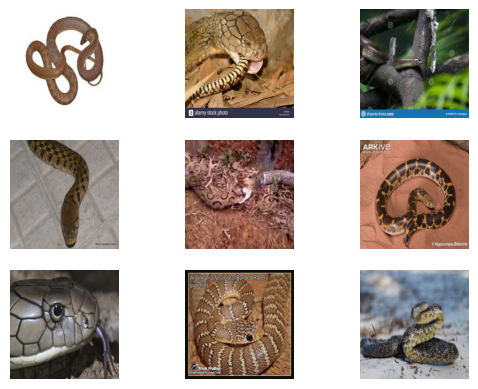

In [28]:
#to visualize data

n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

In [29]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 30  # Increased, since we'll use early stopping

In [30]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
# CNN Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.output = nn.Linear(128, len(data_df["labels"].unique()))

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(self.fc1(x))
        x = self.output(x)
        return x


In [32]:
model = Net().to(device)

In [33]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [34]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Halve LR every 5 epochs


In [35]:
# Training with Early Stopping
best_val_loss = float('inf')
patience = 3
counter = 0

train_loss_plot, val_loss_plot = [], []
train_acc_plot, val_acc_plot = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = (train_correct / len(train_dataset)) * 100
    val_acc = (val_correct / len(val_dataset)) * 100
    train_loss_plot.append(round(train_loss / 1000, 4))
    val_loss_plot.append(round(val_loss / 1000, 4))
    train_acc_plot.append(round(train_acc, 2))
    val_acc_plot.append(round(val_acc, 2))

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/1000:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/1000:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break




Epoch 1/30, Train Loss: 0.1299, Train Acc: 53.81%, Val Loss: 0.0200, Val Acc: 60.78%
Epoch 2/30, Train Loss: 0.0927, Train Acc: 56.67%, Val Loss: 0.0179, Val Acc: 56.54%
Epoch 3/30, Train Loss: 0.0947, Train Acc: 59.96%, Val Loss: 0.0331, Val Acc: 61.44%
Epoch 4/30, Train Loss: 0.0846, Train Acc: 61.98%, Val Loss: 0.0147, Val Acc: 62.09%
Epoch 5/30, Train Loss: 0.0909, Train Acc: 59.26%, Val Loss: 0.0149, Val Acc: 68.30%
Epoch 6/30, Train Loss: 0.0664, Train Acc: 65.48%, Val Loss: 0.0178, Val Acc: 55.23%
Epoch 7/30, Train Loss: 0.0551, Train Acc: 68.27%, Val Loss: 0.0143, Val Acc: 60.78%
Epoch 8/30, Train Loss: 0.0575, Train Acc: 70.44%, Val Loss: 0.0146, Val Acc: 61.11%
Epoch 9/30, Train Loss: 0.0532, Train Acc: 69.95%, Val Loss: 0.0151, Val Acc: 63.73%
Epoch 10/30, Train Loss: 0.0524, Train Acc: 71.91%, Val Loss: 0.0142, Val Acc: 61.11%
Epoch 11/30, Train Loss: 0.0466, Train Acc: 74.77%, Val Loss: 0.0128, Val Acc: 68.63%
Epoch 12/30, Train Loss: 0.0481, Train Acc: 73.45%, Val Loss: 0

In [36]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()


print(f"Accuracy Score is: {round((total_acc_test / len(test_dataset)) * 100, 4)} and Loss is: {round(total_loss_test / 1000, 4)}")


Accuracy Score is: 60.2606 and Loss is: 0.0132


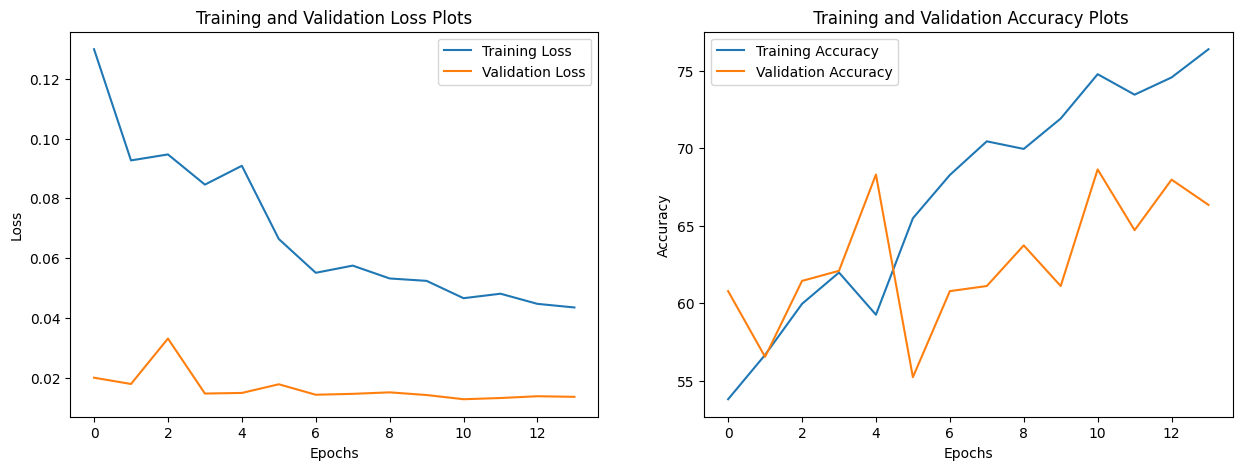

In [37]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(train_loss_plot, label = "Training Loss")
axs[0].plot(val_loss_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss Plots")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(train_acc_plot, label = "Training Accuracy")
axs[1].plot(val_acc_plot, label = "Validation Accuracy")
axs[1].set_title(" Training and Validation Accuracy Plots")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [44]:
#1- read image
#2- Transform using transform object
#3- predict through the model
#4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  print(image.shape)
  output = model(image.unsqueeze(0))

  output = torch.argmax(output, axis = 1).item()

  return label_encoder.inverse_transform([output])

In [47]:
predict_image("/content/animals_hero_cobra.jpg")

torch.Size([3, 128, 128])


array(['Venomous'], dtype=object)